{% include toc title="On This Page" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this lesson, you will be able to:

* Create a list of landsat `.tif` files using `glob` and `os.path.join`
* Crop a list of landsat `.tif` files to a defined crop extent boundary
* Stack a list of landsat `.tif` into a **xarray** DataFrame

</div>

### Landsat File Naming Convention

Landsat and many other satellite remote sensing data is named in a way that tells you a about:

* When the data were collected and processed
* What sensor was used to collect the data
* What satellite was used to collect the data.

And more. 

Here you will learn a few key components of the landsat 8 collection file name. The first scene that you work with below is named:

`LC080340322016072301T1-SC20180214145802`

At the start of the name, you see LC08:

* **L:** Landsat Sensor
* **C:** OLI / TIRS combined platform
* **08:** Landsat 8 (not 7)

* **034032:** The next 6 digits represent the path and row of the scene. This identifies the spatial coverage of the scene

Finally, you have a date. In your case as follows:

* **20160723:** representing the year, month and day that the data were collected.

The second part of the file name above tells you more about when the data were last processed. You can read more about this naming convention using the link below.

<a href="https://www.usgs.gov/faqs/what-naming-convention-landsat-collections-level-1-scenes?qt-news_science_products=0#qt-news_science_products" target="_blank">Learn more about Landsat 8 file naming conventions.</a>

As you work with these data, it is good to double check that you are working with the sensor (Landsat 8) and the time period that you intend. Having this information in the file name makes it easier to keep track of this as you process your data. 

## Open Landsat .tif Files in Python

Now that you understand the Landsat 8 Collection file naming conventions, you 
will bring the data into Python using **rioxarray**. To begin, load your 
libraries and set up your working directory.

In [2]:
import os
from glob import glob

import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import numpy as np
import numpy.ma as ma
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import mapping


# Download data and set working directory
data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

You will be working in the `landsat-collect` directory. Notice that the data in that directory are stored by individual band. Each file is a single geotiff (.tif) rather than one tif with all the bands which is what you worked with in the previous lesson with NAIP data.  

### Why Are Landsat Bands Stored As Individual Files?
 
Originally Landsat was stored in a file format called HDF - hierarchical
data format. However that format, while extremely efficient, is a bit more
challenging to work with. In recent years, USGS has started to make each band
of a landsat scene available as a `.tif` file. This makes it a bit easier to use
across many different programs and platforms.

The good news is that you already know how to work with .tif files in **Python**. You just need to learn how to batch process a series of `.tif` files to work with Landsat 8 Collections. 

## Generate a List of Files in Python
 
To begin, explore the Landsat files in your `cs-test-landsat` directory. Start with the data:

`data/cs-test-landsat/`

Landsat scenes are large. In order to make the process more effecient, you need to crop all of the data in your landsat scenes to be the size of our study area. You will be using `crop_all()` later in this lesson to achieve this goal. 

Below are all of the bands in our landsat data:

```
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band7.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1.xml',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band5.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band1.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_aerosol.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band3.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_ANG.txt',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band2.tif',
'crop',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band4.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band6.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_pixel_qa.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_radsat_qa.tif',
'LC08_L1TP_034032_20160621_20170221_01_T1_MTL.txt'

```

Notice that there are some layers that are quality assurance layers. Others have the word band in them. The layers with band in them are the reflectance data that you need to work with. 

To work with these files, you will do the following:

1. You will generate a list of all files in the directory that contain the word **band** in the name. 
2. Crop all layers in that list to the extent of the study area.
3. Stack all the layers into one numpy array.

You will use the `glob()` function and library to do this in **Python**. 

Begin exploring `glob()` by grabbing everything in the directory using `/*`. 

In [3]:
landsat_post_fire_path = os.path.join("cold-springs-fire",
                                      "landsat_collect",
                                      "LC080340322016072301T1-SC20180214145802",
                                      "crop")

glob(os.path.join(landsat_post_fire_path, "*"))

['cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_radsat_qa_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band7_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif.aux.xml',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_pixel_qa_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif

### Grab Subsets of File Names Using File Names and Other Criteria 

Above you generated a list of all files in the directory. However, you may want to subset that list to only include:

1. `.tif` files
2. `.tif` files that contain the word "band" in them

Note that it is important that the file **ends with** .tif. So we use an asterisk at the end of the path to tell Python to only grab files that end with .tif.

`path/*.tif` will grab all files in the crop directory that end with the .tif extension. 

In [4]:
glob(os.path.join(landsat_post_fire_path, "*.tif"))

['cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_radsat_qa_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band7_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_pixel_qa_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'col

To only grab files containing the word band AND that end with `.tif` we use `*band*.tif`.
This tells python to look for the word band anywhere before the `.tif` extension AND anywhere within the file name. You can use number ranges to JUST get the bands you need. For this exercise, we will use all of the bands. But if you were just working with RGB images, you could filter this further by specifying `*band[2-4]*.tif`. 


In [5]:
all_landsat_post_bands = glob(os.path.join(landsat_post_fire_path,
                                           "*band*.tif"))
all_landsat_post_bands

['cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band7_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif']

Be sure that your bands are in order starting at 1 and ending at 7! If the data are not in order, you can use the `.sort()` list method to sort your list alphabetically. The data in this lesson are sorted properly; however, we have noticed that this sort doesn't happen by default on some machines. The code below will sort your list.

In [6]:
all_landsat_post_bands.sort()
all_landsat_post_bands

['cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band7_crop.tif']

In the previous lesson, you learned how to stack and plot landsat bands using the 
function below. Use that to create a new xarray object.

In [12]:
def combine_tifs(tif_list):
    """A function that combines a list of tifs in the same CRS
    and of the same extent into an xarray object

    Parameters
    ----------
    tif_list : list
        A list of paths to the tif files that you wish to combine.

    Returns
    -------
    An xarray object with all of the tif files in the listmerged into 
    a single object.

    """

    out_xr = []
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True).squeeze())
        out_xr[i]["band"] = i+1

    return xr.concat(out_xr, dim="band")

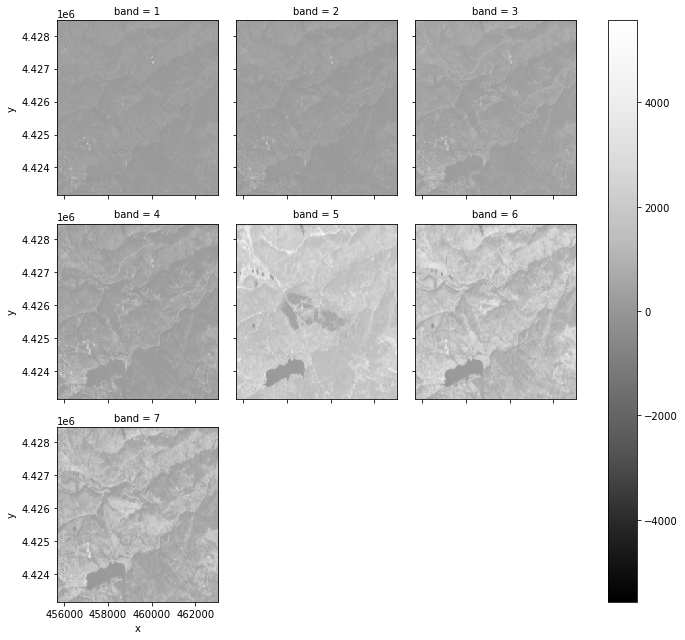

In [17]:
landsat_post_xr = combine_tifs(all_landsat_post_bands)

# Plot the data
landsat_post_xr.plot.imshow(col="band",
                            col_wrap=3,
                            cmap="Greys_r")
plt.show()

### Crop a Landsat Band Using Rioxarray `rio.clip()`

Above you opened up the data and plotted. Often, you want to crop
your data to just your study area - removing some of the data that you 
don't need in your analysis. You could chose to open and crop each file 
individually using the `rxr.open_rasterio()` function alongside 
the **rioxarray** `opened_xarray.rio.clip()` function as shown below.

In order to crop a band, you need to have a

1. **GeoPandas** or **shapely** object that represents the extent of the area you want to study in the Landsat image (your crop extent). 
2. The crop extent shapefile and the Landsat data need to be in the same Coordinate Reference System, or CRS. 

To clip an **xarray** DataFrame to a **GeoPandas** extent, you need to create the clipped dataframe with the following syntax.

```
clipped_xarray = xarray_name.rio.clip(geopandas_object_name.geometry.apply(mapping))
```

HINT: You can check the CRS of your Landsat data using `xarray_name.rio.crs`. 

Below you crop your stacked data.

In [19]:
# Open up boundary extent in GeoPandas
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

fire_boundary = gpd.read_file(fire_boundary_path)


# Reproject data to CRS of raster data
fire_boundary_utmz13 = fire_boundary.to_crs(landsat_post_xr.rio.crs)
# Clip the data
landsat_post_xr_clip = landsat_post_xr.rio.clip(
    fire_boundary_utmz13.geometry.apply(mapping))

# Notice the x and y data dimensions have changed
landsat_post_xr_clip

<xarray.DataArray (band: 7, y: 44, x: 112)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 4.426e+06 4.426e+06 ... 4.425e+06 4.425e+06
  * x            (x) float64 4.577e+05 4.577e+05 4.577e+05 ... 4.61e+05 4.61e+05
  * band         (band) int64 1 2 3 4 5 6 7
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:  3483
    STATISTICS_MEAN:     297.16466859584
    STATISTICS_MINIMUM:  -57
    STATISTICS_STDDEV:   119.61370418167
    scale_factor:        1.0
    add_offset:          0.0
    grid_mapping:        spatial_ref

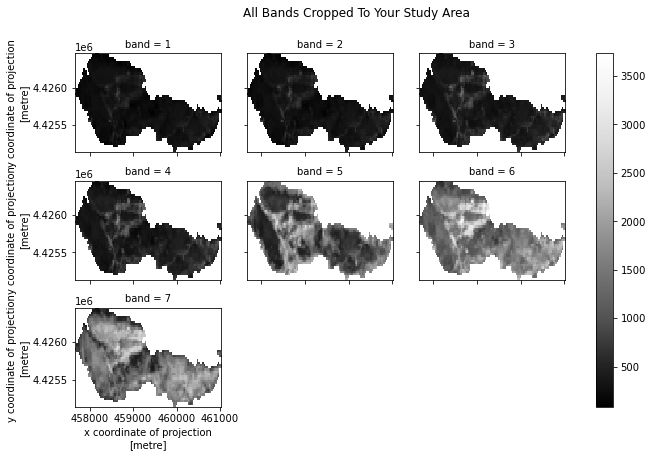

In [30]:
# Plot the data

ax = landsat_post_xr_clip.plot.imshow(col="band", col_wrap=3,
                                      cmap="Greys_r",
                                      figsize=(10, 6))

plt.suptitle("All Bands Cropped To Your Study Area",
             y=1.05)
plt.show()

## Use Crop the Stacked Xarray

**rioxarray** makes cropping stacked arrays easy! Since we already stacked 
the list of landsat images into a single array earlier in the lesson, we can 
use the same cropping process that was used to crop a single band of the landsat
imagery. 

### Plot Your Raster Stack Using EarthPy (OPTIONAL)

Once you have cropped your stacked data, you can plot it or work with it as you need to.


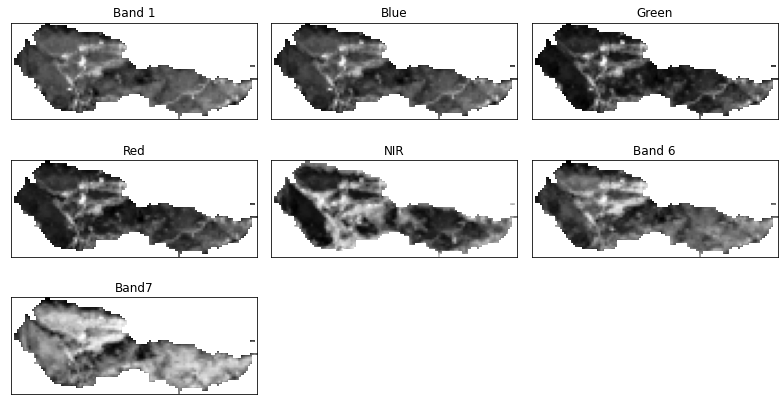

In [35]:
# Plot all bands using earthpy
band_titles = ["Band 1",
               "Blue",
               "Green",
               "Red",
               "NIR",
               "Band 6",
               "Band7"]

ep.plot_bands(landsat_post_xr_clip,
              figsize=(11, 6),
              title=band_titles,
              cbar=False)
plt.show()

### Plot Your Raster Stack in Color

Sometimes, you want to plot your raster stack using multiple bands to display the color of an area. This can be difficult, as plotting stacked bands with `nan` values in it, like the cropped images above, can cause issues. To get around this, you can mask the `nan` values out of your raster and plot the output masked array using Earthpy's `plot_rbg` function. You can create a mask of where `nan` values are with `np.isnan(array_name)`, and apply it with `ma.masked_array(original_array, numpy_mask)`.

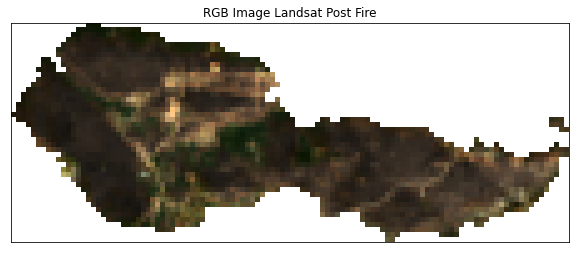

In [34]:
# Create nan mask
mask_nan = np.isnan(landsat_post_xr_clip)

# Apply nan mask to cropped data
landsat_post_arr_masked = ma.masked_array(landsat_post_xr_clip,
                                          mask=mask_nan)

# Plot masked array
ep.plot_rgb(landsat_post_arr_masked,
            rgb=[3, 2, 1],
            title="RGB Image Landsat Post Fire")

plt.show()